In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot  as plt
from tensorflow.keras.optimizers import SGD
import os
import glob
import shutil

In [2]:
base_dir=r"C:\Users\holar\Downloads\Xoup"
classes=['afang','egusi','ewedu','oha','okro']

In [9]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpeg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

afang: 159 Images
egusi: 182 Images
ewedu: 155 Images
oha: 209 Images
okro: 154 Images


In [3]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [4]:
batch_size=60
img=150
IMG=224

In [5]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.5, rotation_range=0.7,
                              height_shift_range=0.2, width_shift_range=0.2)

train_data_gen = image_gen.flow_from_directory( directory=train_dir, target_size=(img, img),
                                               shuffle=True, batch_size=batch_size
                                               )

Found 687 images belonging to 5 classes.


In [6]:
image_gen=ImageDataGenerator(rescale=1./255)

val_data_gen=image_gen.flow_from_directory(target_size=(img,img), directory=val_dir, batch_size=batch_size, 
                                           shuffle=False, class_mode='categorical')

Found 172 images belonging to 5 classes.


In [7]:
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3,input_shape=(img, img, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(256,3, padding='same', activation='relu'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.0001), metrics=['accuracy'])
EPOCHS = 5

history = model.fit_generator(train_data_gen, 
                             steps_per_epoch=int(np.ceil(train_data_gen.n/float(batch_size))),
                             epochs=EPOCHS,
                             validation_data=val_data_gen,
                             validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))))

Epoch 1/5
12/12 [==============================] - 19s 2s/step - loss: 1.6092 - accuracy: 0.1965 - val_loss: 1.6122 - val_accuracy: 0.1802
Epoch 2/5
12/12 [==============================] - 19s 2s/step - loss: 1.6091 - accuracy: 0.2227 - val_loss: 1.6121 - val_accuracy: 0.1802
Epoch 3/5
12/12 [==============================] - 19s 2s/step - loss: 1.6129 - accuracy: 0.1674 - val_loss: 1.6120 - val_accuracy: 0.1802
Epoch 4/5
12/12 [==============================] - 19s 2s/step - loss: 1.6109 - accuracy: 0.2096 - val_loss: 1.6119 - val_accuracy: 0.1802
Epoch 5/5
 9/12 [=====================>........] - ETA: 4s - loss: 1.6141 - accuracy: 0.1854

KeyboardInterrupt: 

In [13]:
image_gen_train = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.45, rotation_range=0.45,
                                    width_shift_range=0.15, height_shift_range=0.15)

train_data_gen=image_gen_train.flow_from_directory(shuffle=True, target_size=(IMG, IMG), directory=train_dir,
                                                  batch_size=batch_size)



Found 687 images belonging to 5 classes.


In [14]:
image_gen_train = ImageDataGenerator(rescale=1./255)

val_data_gen=image_gen_train.flow_from_directory(target_size=(IMG, IMG), directory=val_dir,
                                                 batch_size=batch_size, class_mode='categorical')

Found 172 images belonging to 5 classes.


In [15]:
url=r"https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
feature_extractor=hub.KerasLayer(url, input_shape=(IMG,IMG,3))

In [16]:
model=tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(5, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              3540265   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5010      
Total params: 3,545,275
Trainable params: 5,010
Non-trainable params: 3,540,265
_________________________________________________________________


In [22]:
model.compile(
  optimizer=SGD(lr=0.01),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 100
history = model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_data_gen)

Train for 12 steps, validate for 3 steps
Epoch 1/100
12/12 [==============================] - 28s 2s/step - loss: 0.8350 - accuracy: 0.6841 - val_loss: 0.9136 - val_accuracy: 0.6628
Epoch 2/100
12/12 [==============================] - 24s 2s/step - loss: 0.7710 - accuracy: 0.7045 - val_loss: 0.8938 - val_accuracy: 0.6802
Epoch 3/100
12/12 [==============================] - 24s 2s/step - loss: 0.8534 - accuracy: 0.7089 - val_loss: 0.9064 - val_accuracy: 0.7035
Epoch 4/100
12/12 [==============================] - 23s 2s/step - loss: 0.7782 - accuracy: 0.7132 - val_loss: 0.8574 - val_accuracy: 0.7209
Epoch 5/100
12/12 [==============================] - 21s 2s/step - loss: 0.7726 - accuracy: 0.7162 - val_loss: 0.8598 - val_accuracy: 0.6802
Epoch 6/100
12/12 [==============================] - 23s 2s/step - loss: 0.7695 - accuracy: 0.7336 - val_loss: 0.8618 - val_accuracy: 0.7093
Epoch 7/100
12/12 [==============================] - 21s 2s/step - loss: 0.7258 - accuracy: 0.7365 - val_loss: 0.

KeyboardInterrupt: 

In [50]:
model.save(r"C:\Users\holar\Downloads\Xoup\accurate soup model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: C:\Users\holar\Downloads\Xoup\accurate soup model\assets


INFO:tensorflow:Assets written to: C:\Users\holar\Downloads\Xoup\accurate soup model\assets


In [51]:
model=tf.keras.models.load_model(r"C:\Users\holar\Downloads\Xoup\accurate soup model")
model

In [42]:
import pandas as pd
test_dir=r"C:\Users\holar\Downloads\book classification\soup"
image_gen=ImageDataGenerator(rescale=1./255)
test_gen=image_gen.flow_from_directory(directory=test_dir, target_size=(224,224), shuffle=False)
predict=model.predict(test_gen)
predict=predict*100
names=['afang','egusi','ewedu','oha','okro']
df=pd.DataFrame(predict,columns=[names])
print(df)

Found 40 images belonging to 1 classes.
        afang      egusi      ewedu        oha       okro
0    1.635283   0.255962   6.523319   1.969903  89.615532
1    0.076221   0.140277  99.261681   0.321084   0.200729
2   92.147560   1.681011   2.779307   2.769184   0.622936
3    0.038960   0.169901  97.955338   0.197139   1.638672
4    0.029203   0.000287  99.635399   0.243362   0.091756
5   24.849152   3.998960  20.773512  50.141941   0.236427
6    1.236552   0.021485  97.529503   0.035705   1.176755
7    0.425372   0.008992  98.409515   0.092957   1.063161
8    0.405693   0.000112  99.587700   0.005830   0.000662
9    0.110158   0.023697  99.071487   0.673460   0.121191
10   0.067346   0.078252  94.143929   0.034849   5.675637
11   7.081971   0.029605  55.379711  34.226803   3.281905
12   0.064885   0.000549  99.572029   0.235316   0.127207
13   1.564070   0.058943  19.526318  74.556229   4.294443
14   1.916053   0.561463  96.857872   0.638236   0.026378
15   0.489769   0.174703  98.339

afang     1.635283
egusi     0.255962
ewedu     6.523319
oha       1.969903
okro     89.615532
Name: 0, dtype: float32


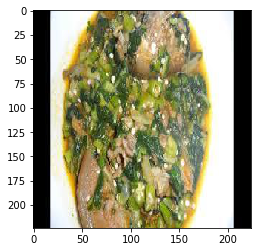

In [43]:
plt.imshow(test_gen[0][0][0])
print(df.iloc[0])

afang     0.076221
egusi     0.140277
ewedu    99.261681
oha       0.321084
okro      0.200729
Name: 1, dtype: float32


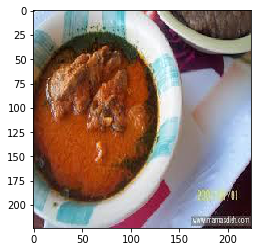

In [44]:
plt.imshow(test_gen[0][0][1])
print(df.iloc[1])

afang    92.147560
egusi     1.681011
ewedu     2.779307
oha       2.769184
okro      0.622936
Name: 2, dtype: float32


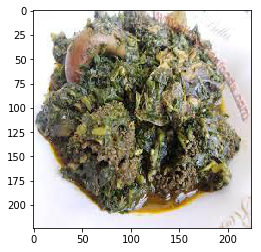

In [45]:
plt.imshow(test_gen[0][0][2])
print(df.iloc[2])

afang    0.000390
egusi    0.001699
ewedu    0.979553
oha      0.001971
okro     0.016387
Name: 3, dtype: float32


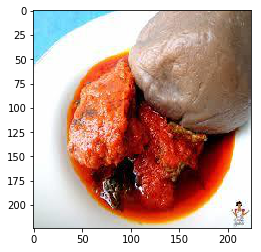

In [28]:
plt.imshow(test_gen[0][0][3])
print(df.iloc[3])

afang    0.000292
egusi    0.000003
ewedu    0.996354
oha      0.002434
okro     0.000918
Name: 4, dtype: float32


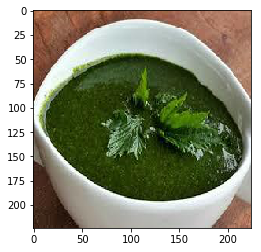

In [29]:
plt.imshow(test_gen[0][0][4])
print(df.iloc[4])

afang    0.248492
egusi    0.039990
ewedu    0.207735
oha      0.501419
okro     0.002364
Name: 5, dtype: float32


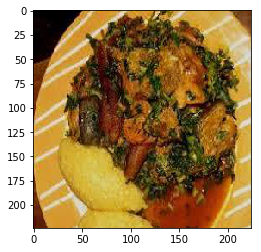

In [30]:
plt.imshow(test_gen[0][0][5])
print(df.iloc[5])

afang    0.012366
egusi    0.000215
ewedu    0.975295
oha      0.000357
okro     0.011768
Name: 6, dtype: float32


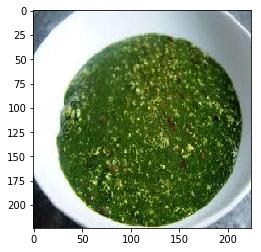

In [31]:
plt.imshow(test_gen[0][0][6])
print(df.iloc[6])

afang    0.004254
egusi    0.000090
ewedu    0.984095
oha      0.000930
okro     0.010632
Name: 7, dtype: float32


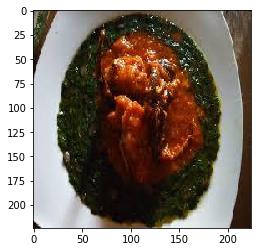

In [32]:
plt.imshow(test_gen[0][0][7])
print(df.iloc[7])

afang    0.004057
egusi    0.000001
ewedu    0.995877
oha      0.000058
okro     0.000007
Name: 8, dtype: float32


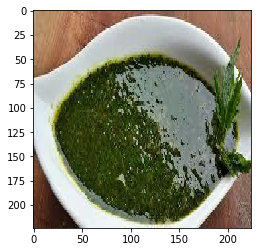

In [33]:
plt.imshow(test_gen[0][0][8])
print(df.iloc[8])

afang    0.001102
egusi    0.000237
ewedu    0.990715
oha      0.006735
okro     0.001212
Name: 9, dtype: float32


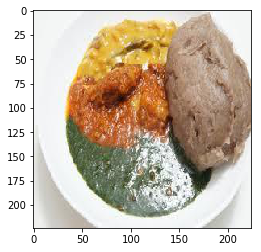

In [34]:
plt.imshow(test_gen[0][0][9])
print(df.iloc[9])

afang    0.000673
egusi    0.000783
ewedu    0.941439
oha      0.000348
okro     0.056756
Name: 10, dtype: float32


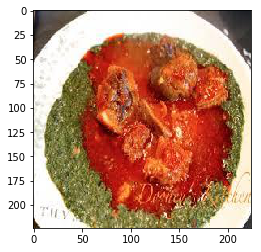

In [35]:
plt.imshow(test_gen[0][0][10])
print(df.iloc[10])

afang    0.070820
egusi    0.000296
ewedu    0.553797
oha      0.342268
okro     0.032819
Name: 11, dtype: float32


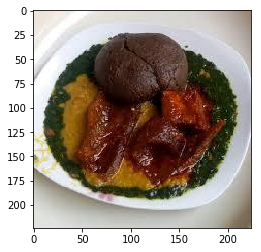

In [37]:
plt.imshow(test_gen[0][0][11])
print(df.iloc[11])

afang    0.012710
egusi    0.909319
ewedu    0.001781
oha      0.041382
okro     0.034808
Name: 17, dtype: float32


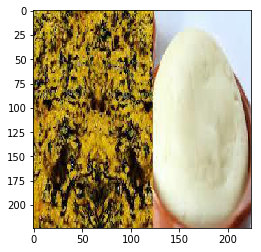

In [39]:
plt.imshow(test_gen[0][0][17])
print(df.iloc[17])

afang     3.976304
egusi    83.925369
ewedu     0.032810
oha      12.051370
okro      0.014160
Name: 16, dtype: float32


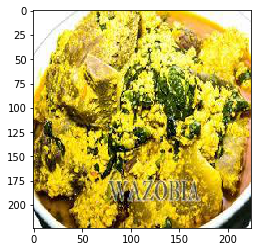

In [46]:
plt.imshow(test_gen[0][0][16])
print(df.iloc[16])

afang     0.674066
egusi    74.378265
ewedu    12.845418
oha       4.148276
okro      7.953984
Name: 24, dtype: float32


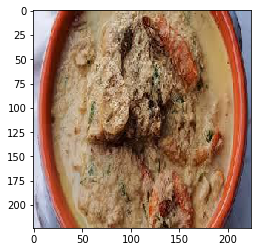

In [48]:
plt.imshow(test_gen[0][0][24])
print(df.iloc[24])

afang     4.157506
egusi    90.956192
ewedu     0.133035
oha       2.541562
okro      2.211704
Name: 25, dtype: float32


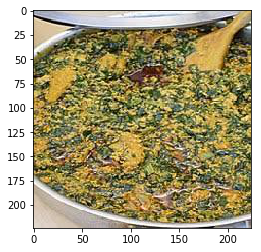

In [49]:
plt.imshow(test_gen[0][0][25])
print(df.iloc[25])

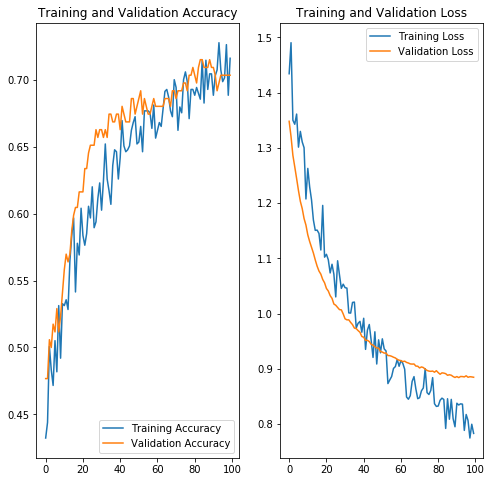

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()